In [ ]:
import torch
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from transformers import CLIPProcessor, CLIPTextModel
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# --- ⚠️ CHANGE THIS PATH ---
# Point this to the exact location of your dataset.zip file on Google Drive
DRIVE_ZIP_PATH = "/content/drive/MyDrive/Dataset.zip"
# ---

LOCAL_ZIP_PATH = "/content/Dataset.zip"
BASE_UNZIP_DIR = "/content/unzipped_data" # We'll unzip into this folder

# 2. Copy the zip file from Drive to Colab's fast local disk
print("Copying dataset.zip from Drive to Colab...")
!cp "{DRIVE_ZIP_PATH}" {LOCAL_ZIP_PATH}
print("Copy complete.")

# 3. Unzip the dataset
print("Unzipping dataset...")
!unzip -q {LOCAL_ZIP_PATH} -d {BASE_UNZIP_DIR}
print("Unzip complete.")

# 4. Set your file paths (FIX APPLIED)
# -----------------------------------------------------------------
# Your zip file likely contained a 'Dataset' folder.
# So the path is /content/unzipped_data/Dataset/images/images_normalized
# We must specify that nested folder.

NESTED_FOLDER_NAME = "Dataset" # This is the folder from your zip
DATA_DIR = os.path.join(BASE_UNZIP_DIR, NESTED_FOLDER_NAME)

print(f"Base data directory set to: {DATA_DIR}")
# -----------------------------------------------------------------

IMAGE_DIR = os.path.join(DATA_DIR, "images/images_normalized")
MASK_DIR = os.path.join(DATA_DIR, "masked")
REPORTS_CSV = os.path.join(DATA_DIR, "indiana_reports.csv")

# 5. Check that everything is loaded correctly
try:
    print(f"Total unannotated images: {len(os.listdir(IMAGE_DIR))}")
    print(f"Total annotated masks: {len(os.listdir(MASK_DIR))}")
    print("✅ Paths are correct!")
except FileNotFoundError:
    print("❌ ERROR: FileNotFoundError.")
    print(f"Make sure this path is correct: {IMAGE_DIR}")
    print("Check the output of this 'ls' command to see your folder structure:")
    !ls {BASE_UNZIP_DIR}

# 6. Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mounted at /content/drive
Copying dataset.zip from Drive to Colab...
Copy complete.
Unzipping dataset...
Unzip complete.
Base data directory set to: /content/unzipped_data/Dataset
Total unannotated images: 7470
Total annotated masks: 239
✅ Paths are correct!
Using device: cuda


In [ ]:
!pip install segmentation-models-pytorch -q
import segmentation_models_pytorch as smp

# 1. Dataset for ALL images (unlabeled)
class UnlabeledXrayDataset(Dataset):
    def __init__(self, image_dir, transform):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.image_paths[idx]).convert("RGB")
            return self.transform(img)
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            return torch.zeros((3, IMAGE_SIZE, IMAGE_SIZE))

# 2. Define Image Transformations
IMAGE_SIZE = 256
img_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 3. Create the Autoencoder (a U-Net)
print("Loading pre-training model from segmentation-models-pytorch...")

# --- REPLACED CODE ---
# We use a standard U-Net with a ResNet34 encoder
pretrain_model = smp.Unet(
    encoder_name="resnet34",        # Fast and powerful encoder
    encoder_weights="imagenet",   # Start with ImageNet weights
    in_channels=3,
    classes=3                     # Output 3 channels (for RGB reconstruction)
)
# ---
pretrain_model.to(device)
print("Model loaded.")

# 4. Create DataLoader for all images
unlabeled_dataset = UnlabeledXrayDataset(IMAGE_DIR, img_transform)
pretrain_loader = DataLoader(unlabeled_dataset, batch_size=16, shuffle=True, num_workers=2)

# 5. Pre-training Loop
optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
num_pretrain_epochs = 3

print("--- Starting Phase 1: Pre-training Autoencoder ---")
for epoch in range(num_pretrain_epochs):
    pretrain_model.train()
    total_loss = 0
    for i, images in enumerate(pretrain_loader):
        images = images.to(device)

        optimizer.zero_grad()
        reconstructed_images = pretrain_model(images)
        loss = loss_fn(reconstructed_images, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"==> Epoch {epoch+1}/{num_pretrain_epochs} Average Loss: {total_loss / len(pretrain_loader):.4f}")

# 6. 💾 Save the trained ENCODER weights to your Drive
# The 'smp' model also has a '.encoder' attribute, so this code is unchanged
ENCODER_WEIGHTS_PATH = "/content/drive/MyDrive/my_pretrained_encoder.pth"
torch.save(pretrain_model.encoder.state_dict(), ENCODER_WEIGHTS_PATH)
print(f"--- Phase 1 Complete. Encoder weights saved to {ENCODER_WEIGHTS_PATH} ---")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.4 MB/s eta 0:00:00
Loading pre-training model from segmentation-models-pytorch...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Model loaded.
--- Starting Phase 1: Pre-training Autoencoder ---


In [ ]:
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn as nn
from transformers import CLIPProcessor, CLIPTextModel
from sklearn.model_selection import train_test_split
import re # Import regular expressions

# --- Point this to the folder containing your 239 ORIGINAL X-rays ---
LABELED_IMAGE_DIR = os.path.join(DATA_DIR, "images/images_normalized")
# ---

# 1. Dataset for Labeled data (image, text, mask)
class LabeledXrayDataset(Dataset):
    def __init__(self, mask_filenames, mask_dir, image_dir, uid_to_report_map, processor, img_transform, mask_transform):
        self.mask_filenames = mask_filenames
        self.mask_dir = mask_dir
        self.image_dir = image_dir # This will be the LABELED_IMAGE_DIR
        self.uid_to_report_map = uid_to_report_map
        self.processor = processor
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.mask_filenames)

    def __getitem__(self, idx):
        # 1. Start with the mask filename
        mask_filename = self.mask_filenames[idx]

        # 2. ASSUMPTION: The image has the same filename as the mask
        img_path = os.path.join(self.image_dir, mask_filename)
        mask_path = os.path.join(self.mask_dir, mask_filename)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # Grayscale

        # 3. Parse the mask filename to find the UID
        uid_match = re.search(r'^(\d+)_', mask_filename)
        report_text = "No findings."

        if uid_match:
            uid = int(uid_match.group(1)) # Get the UID as an integer
            # 4. Use the UID to find the report
            report_text = self.uid_to_report_map.get(uid, "No findings.")
        else:
            print(f"Warning: Could not parse UID from {mask_filename}")

        # Force the report_text to be a string to handle NaN/float values
        report_text = str(report_text)

        # 5. Process text
        text_inputs = self.processor(text=report_text, return_tensors="pt", padding="max_length", truncation=True, max_length=77)

        return self.img_transform(image), text_inputs['input_ids'].squeeze(0), self.mask_transform(mask)

# 2. Define Mask Transform
mask_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
])


# --- 🎯 THIS IS THE DATA AUGMENTATION FIX 🎯 ---
# 1. Create a NEW transform list for training data
train_img_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # Add augmentations
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    # ---
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 2. Create a separate transform for validation images (no augmentation)
val_img_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# --- END OF FIX ---


# 3. Create Labeled DataLoaders
print("Preparing Phase 2 DataLoaders...")

REPORTS_CSV = os.path.join(DATA_DIR, "indiana_reports.csv")
reports_df = pd.read_csv(REPORTS_CSV)
uid_to_report_map = reports_df.set_index('uid')['findings'].to_dict()

labeled_mask_filenames = os.listdir(MASK_DIR)
print(f"Found {len(labeled_mask_filenames)} mask files in {MASK_DIR}.")

# --- PRE-FILTERING STEP ---
valid_mask_files = []
for mask_file in labeled_mask_filenames:
    if os.path.exists(os.path.join(LABELED_IMAGE_DIR, mask_file)):
        valid_mask_files.append(mask_file)
print(f"Found {len(valid_mask_files)} masks with matching original images.")
# --- END PRE-FILTERING ---

train_mask_files, val_mask_files = train_test_split(valid_mask_files, test_size=0.17, random_state=42)
print(f"Splitting into {len(train_mask_files)} train and {len(val_mask_files)} val masks.")

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Create the datasets, passing the new augmentation transforms
train_dataset = LabeledXrayDataset(
    train_mask_files, MASK_DIR, LABELED_IMAGE_DIR,
    uid_to_report_map, processor,
    train_img_transform,  # <-- Use new transform
    mask_transform
)
val_dataset = LabeledXrayDataset(
    val_mask_files, MASK_DIR, LABELED_IMAGE_DIR,
    uid_to_report_map, processor,
    val_img_transform, # <-- Use new transform
    mask_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

print(f"--- Phase 2: {len(train_dataset)} training samples, {len(val_dataset)} validation samples. ---")

# 4. ⚙️ Define the Final Multimodal Model
class XrayMaskGenerator(nn.Module):
    def __init__(self, encoder_weights_path):
        super().__init__()
        self.image_model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights=None,
            in_channels=3,
            classes=1
        )
        print("Loading pre-trained image encoder weights from Phase 1...")
        self.image_model.encoder.load_state_dict(torch.load(encoder_weights_path))
        print("Pre-trained weights loaded.")

        self.encoder = self.image_model.encoder
        self.decoder = self.image_model.decoder
        self.segmentation_head = self.image_model.segmentation_head

        self.text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
        for param in self.text_model.parameters(): param.requires_grad = False

        self.fusion_conv = nn.Conv2d(512 + 512, 512, kernel_size=1)

    def forward(self, image, text_input_ids):
        enc_features = self.encoder(image)
        bottleneck = enc_features[-1]
        text_features = self.text_model(input_ids=text_input_ids).pooler_output
        text_emb = text_features.unsqueeze(-1).unsqueeze(-1)
        text_emb = text_emb.expand(-1, -1, bottleneck.size(2), bottleneck.size(3))
        fused_features = torch.cat([bottleneck, text_emb], dim=1)
        fused_features = self.fusion_conv(fused_features)
        enc_features[-1] = fused_features

        decoder_output = self.decoder(enc_features)
        mask_output = self.segmentation_head(decoder_output)

        return mask_output

Preparing Phase 2 DataLoaders...
Found 239 mask files in /content/unzipped_data/Dataset/masked.
Found 239 masks with matching original images.
Splitting into 198 train and 41 val masks.
--- Phase 2: 198 training samples, 41 validation samples. ---


In [ ]:
# 1. Define Loss Function
def dice_loss(pred, target, smooth=1.):
    pred = torch.sigmoid(pred) # Apply sigmoid to get 0-1 range
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))
    return loss.mean()

def combined_loss(pred, target):
    # --- 🎯 THIS IS THE WEIGHTED LOSS FIX 🎯 ---
    # We add a 'pos_weight' to the BCE loss.
    # This tells the model to treat '1's (mask pixels) as 99x more important
    # than '0's (background pixels), fighting the class imbalance.
    weight = torch.tensor([99.0]).to(device)
    bce = nn.BCEWithLogitsLoss(pos_weight=weight)(pred, target)
    # --- END OF FIX ---

    dice = dice_loss(pred, target)
    return bce + dice

# 2. Final Training Loop
model = XrayMaskGenerator(ENCODER_WEIGHTS_PATH).to(device)
# Use a very small learning rate for fine-tuning
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_finetune_epochs = 40 # Train for longer on the small, specific dataset

CHECKPOINT_DIR = "/content/drive/MyDrive/xray_final_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "best_model.pth")
best_val_loss = float('inf')

print("--- Starting Phase 2: Fine-tuning Multimodal Model ---")
for epoch in range(num_finetune_epochs):
    model.train()
    total_train_loss = 0
    for images, text_ids, masks in train_loader:
        images, text_ids, masks = images.to(device), text_ids.to(device), masks.to(device)

        optimizer.zero_grad()
        predicted_masks = model(images, text_ids)
        loss = combined_loss(predicted_masks, masks)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, text_ids, masks in val_loader:
            images, text_ids, masks = images.to(device), text_ids.to(device), masks.to(device)
            predicted_masks = model(images, text_ids)
            loss = combined_loss(predicted_masks, masks)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_finetune_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"  ==> New best model saved to {BEST_MODEL_PATH}")

print("--- Phase 2 Complete. Best model saved. ---")

Loading pre-trained image encoder weights from Phase 1...
Pre-trained weights loaded.
--- Starting Phase 2: Fine-tuning Multimodal Model ---
Epoch 1/40 - Train Loss: 34.7679, Val Loss: 31.5170
  ==> New best model saved to /content/drive/MyDrive/xray_final_checkpoints/best_model.pth
Epoch 2/40 - Train Loss: 28.9460, Val Loss: 24.3568
  ==> New best model saved to /content/drive/MyDrive/xray_final_checkpoints/best_model.pth
Epoch 3/40 - Train Loss: 25.2707, Val Loss: 21.5468
  ==> New best model saved to /content/drive/MyDrive/xray_final_checkpoints/best_model.pth
Epoch 4/40 - Train Loss: 23.0157, Val Loss: 20.4899
  ==> New best model saved to /content/drive/MyDrive/xray_final_checkpoints/best_model.pth
Epoch 5/40 - Train Loss: 20.9169, Val Loss: 18.1968
  ==> New best model saved to /content/drive/MyDrive/xray_final_checkpoints/best_model.pth
Epoch 6/40 - Train Loss: 19.5339, Val Loss: 16.7447
  ==> New best model saved to /content/drive/MyDrive/xray_final_checkpoints/best_model.pth
E

Loading pre-trained image encoder weights from Phase 1...
Pre-trained weights loaded.
Best model loaded for visualization.


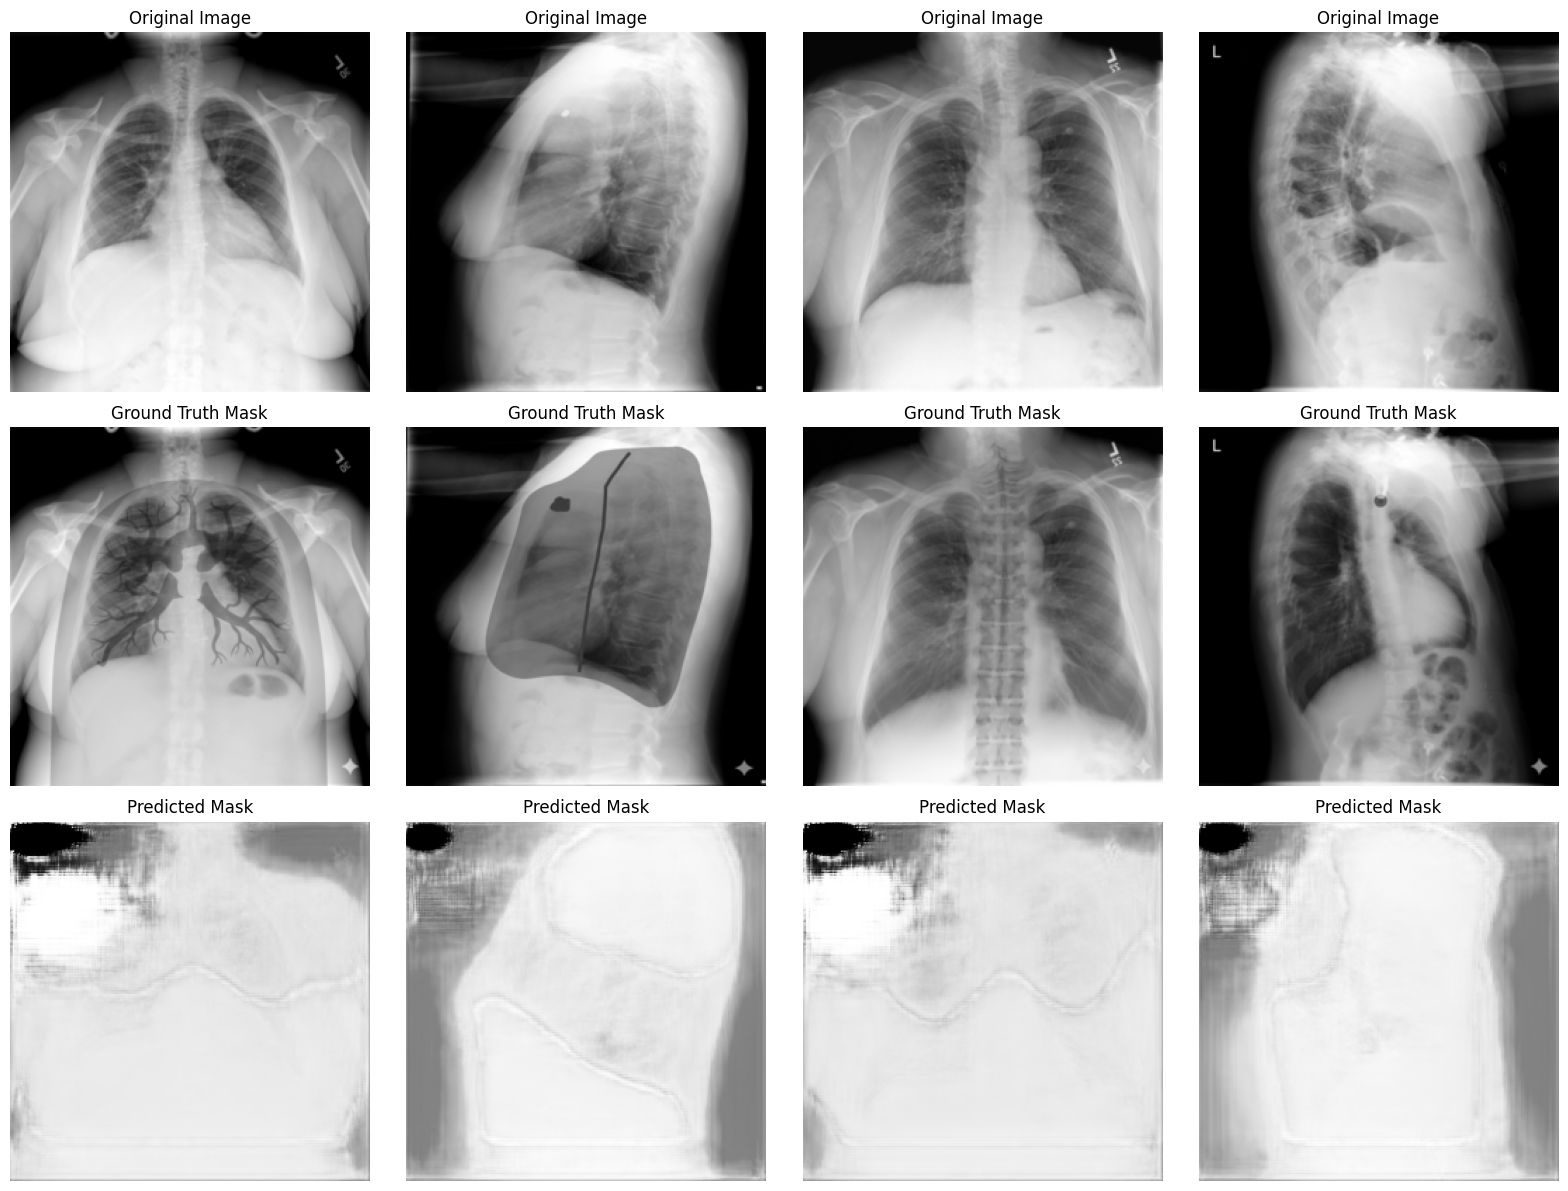

In [ ]:
# 1. Load your best model
BEST_MODEL_PATH = "/content/drive/MyDrive/xray_final_checkpoints/best_model.pth"
# Re-initialize the model structure
model = XrayMaskGenerator(ENCODER_WEIGHTS_PATH).to(device)
# Load the fine-tuned weights
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
print("Best model loaded for visualization.")

# 2. Get a batch of validation data
images, text_ids, masks = next(iter(val_loader))
images, text_ids, masks = images.to(device), text_ids.to(device), masks.to(device)

# 3. Run inference
with torch.no_grad():
    predicted_masks = model(images, text_ids)

# 4. Move data to CPU for plotting and apply sigmoid
images_cpu = images.cpu()
masks_cpu = masks.cpu()
predicted_masks_cpu = torch.sigmoid(predicted_masks).cpu() # Apply sigmoid

# 5. Helper function to un-normalize images for viewing
def unnormalize(tensor):
    # Clones to avoid in-place modification
    tensor = tensor.clone()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1) # Ensure values are 0-1
    return tensor.permute(1, 2, 0) # [C, H, W] -> [H, W, C]

# 6. Plot the results
num_images_to_show = 4
plt.figure(figsize=(16, 12))

for i in range(num_images_to_show):
    # Original Image
    ax = plt.subplot(3, num_images_to_show, i + 1)
    plt.imshow(unnormalize(images_cpu[i]))
    ax.set_title("Original Image")
    ax.axis("off")

    # Ground Truth Mask
    ax = plt.subplot(3, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(masks_cpu[i].squeeze(), cmap="gray")
    ax.set_title("Ground Truth Mask")
    ax.axis("off")

    # Predicted Mask
    ax = plt.subplot(3, num_images_to_show, i + 1 + 2 * num_images_to_show)
    plt.imshow(predicted_masks_cpu[i].squeeze(), cmap="gray")
    ax.set_title("Predicted Mask")
    ax.axis("off")

plt.tight_layout()
plt.show()